# Project 1 - MTA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline


## 1. Looking at a single Public MTA dataset 

Below we read a week's worth of turnstile dataset for MTA subway system in NYC.

In [2]:
data = pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_190330.txt")

In [3]:
data.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573


According to the MTA website, the features shown are defined as:

- C/A      = Control Area (A002)
- UNIT     = Remote Unit for a station (R051)
- SCP      = Subunit Channel Position represents an specific address for a device (02-00-00)
- STATION  = Represents the station name the device is located at
- LINENAME = Represents all train lines that can be boarded at this station. Normally lines are represented by one character.  LINENAME 456NQR repersents train server for 4, 5, 6, N, Q, and R trains.
- DIVISION = Represents the Line originally the station belonged to BMT, IRT, or IND   
- DATE     = Represents the date (MM-DD-YY)
- TIME     = Represents the time (hh:mm:ss) for a scheduled audit event
- DESc     = Represent the "REGULAR" scheduled audit event (Normally occurs every 4 hours)
    1. Audits may occur more that 4 hours due to planning, or troubleshooting activities. 
    2. Additionally, there may be a "RECOVR AUD" entry: This refers to a missed audit that was recovered. 
- ENTRIES  = The comulative entry register value for a device
- EXIST    = The cumulative exit register value for a device

The key motive of data exploration in this particular set is to look for some of the more popular stations. We can achieve that by looking at how many passengers use a specific turnstile, or a device located at one (ENTRIES accumulation). Looking at one specific device, we notice a weird trend:

In [4]:
data[(data["STATION"]=="116 ST") & (data["SCP"]=="01-00-01") & (data["C/A"]=='R257') & (data["UNIT"]=='R182')].tail(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
165231,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,05:00:00,REGULAR,92944,52347
165232,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,09:00:00,REGULAR,16796650,37627
165233,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,13:00:00,REGULAR,16796797,37719
165234,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,17:00:00,REGULAR,16797164,37852
165235,R257,R182,01-00-01,116 ST,6,IRT,03/29/2019,21:00:00,REGULAR,16797438,37970


At a certain point in time (around March 29th after 5am), the ENTRIES count jumps up significantly. Considering that there are 13 million people in NYC, it is impossible to have a 4 hour window where more than all of NYC population passes through a single turnstile in a subway station. We can attribute these to unforseen event such as device malfunction, device reset setting entries accumulation at random number, etc. There are also some devices where the opposite happens (sudden huge drop in consecutive audit events)

While many devices do not have this problem, and therefore total number of entries can be calculated, the devices with these problems must be identified. In order to do so, **we are iterating over the whole data, comparing diff between the two entries, and if it is greater than literature value (20 people will pass through a turnstile per min accorindg to [this site](https://www.haywardturnstiles.com/learning-center/before-you-buy/how-many-turnstiles-do-i-need/)), then we flag the station device number.**

In order to accurately calculate the hour difference, we create a feature called "DATETIME" which will be a datetime object (pandas has one).


In [5]:
data["DATETIME"]=data["DATE"]+' '+data["TIME"]
data["DATETIME"]=pd.to_datetime(data["DATETIME"])
data.head(5)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,00:00:00,REGULAR,6989774,2370411,2019-03-23 00:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,04:00:00,REGULAR,6989795,2370413,2019-03-23 04:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,08:00:00,REGULAR,6989813,2370436,2019-03-23 08:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,12:00:00,REGULAR,6989924,2370512,2019-03-23 12:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,03/23/2019,16:00:00,REGULAR,6990200,2370573,2019-03-23 16:00:00


### 1.1. Separate out devices with large jumps in entry values

First step is to determine which devices have unusual jumps in the ENTRIES at some point during the week. We decided on using the 40/Min (to maybe account for busy location and also with a built-in buffer) and multiplied it by to calculate for a week window: 40\*60\*24\*7 ~ 400000. 

In [6]:
MAX_PEOPLE = 400000

data_entries=data.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
data_entries["diff"] = data_entries["max"]-data_entries["min"]
jumps = data_entries[data_entries["diff"] > MAX_PEOPLE].reset_index()
rest = data_entries[data_entries["diff"] <= MAX_PEOPLE]

In [7]:
print("From a total of %d devices" % (len(data_entries)))
print("We see %d devices that have large jumps" % len(jumps))
print("Remaining devices: %d" % len(rest))

From a total of 4849 devices
We see 14 devices that have large jumps
Remaining devices: 4835


In [8]:
jumps.head(5)

,STATION,C/A,UNIT,SCP,max,min,diff
0,116 ST,R257,R182,01-00-01,16797438,87382,16710056
1,121 ST,J037,R009,00-06-00,1265285,458808,806477
2,14 ST-UNION SQ,R221,R170,01-00-01,9643166,25,9643141
3,B'WAY-LAFAYETTE,N519,R461,00-03-01,18107911,7781245,10326666
4,CANARSIE-ROCKAW,H041,R152,00-06-00,33613764,184679,33429085


With a list of devices we know has huge jumps, we can now filter out the original data to exclude all of them.

In [9]:
a=list(jumps["C/A"])
b=list(jumps["UNIT"])
c=list(jumps["SCP"])
d=list(jumps["STATION"])

data_not_jumps=data

for i in range(len(jumps)):
    jump_cond = np.array([a[i],b[i],c[i],d[i]])
    cols = ["C/A","UNIT","SCP","STATION"]
    
    data_not_jumps = data_not_jumps[~((data_not_jumps[cols]==jump_cond).all(1))]

In [17]:
print("Number of Original Datapoints: ", len(data))
print("Number of Datapoints after \"Jump\" data is taken out: ",len(data_not_jumps))

Number of Original Datapoints:  204595
Number of Datapoints after "Jump" data is taken out:  204016


### 1.2: Separate out devices with entry values declining over time

So now we have a partial data set where we removed all the devices from 1.1. We call this subset of the data "data_not_jumps". We can verify that we have removed those 14 devices by calling groupby and counting the list:

In [12]:
data_not_jumps.head(5)
data_not_jumps_entries=data_not_jumps.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
data_not_jumps_entries["diff"] = data_not_jumps_entries["max"]-data_not_jumps_entries["min"]
print("Remaining number of device is still",len(data_not_jumps_entries))



Remaining number of device is still 4835


Now we want to eliminate another set of devices where we notice something else unusual: consecutive audit events shows decrease in ENTRIES; We can capture these by using a for loop:

In [13]:
CA_INDEX = 0
UNIT_INDEX = 1
SCP_INDEX = 2
STATION_INDEX = 3
ENTRY_INDEX = 9
DATETIME_INDEX = 11
NEGATIVE_LIST=[]

for i in range(len(data_not_jumps.index)-1):
    
    entry_1 = data_not_jumps.iloc[i,ENTRY_INDEX]
    entry_2 = data_not_jumps.iloc[i+1,ENTRY_INDEX]
    time_1 = data_not_jumps.iloc[i,DATETIME_INDEX]
    time_2 = data_not_jumps.iloc[i+1,DATETIME_INDEX]
    CA1 = data_not_jumps.iloc[i,CA_INDEX]
    CA2 = data_not_jumps.iloc[i+1,CA_INDEX]
    UNIT1 = data_not_jumps.iloc[i,UNIT_INDEX]
    UNIT2 = data_not_jumps.iloc[i+1,UNIT_INDEX]
    SCP1 = data_not_jumps.iloc[i,SCP_INDEX]
    SCP2 = data_not_jumps.iloc[i+1,SCP_INDEX]
    
    
    if (CA1==CA2) & (SCP1==SCP2) & (UNIT1==UNIT2): # if the two entries are of the same device
        # If the 2nd entry-1st entry is negative
        if (entry_2-entry_1)<0:
            NEGATIVE_LIST.append([CA1,UNIT1,SCP1])

We have a list of the extracted device information (C/A, UNIT and SCP in a list); we can use it to filter out more devices.

In [14]:
neg_set = set(map(tuple,NEGATIVE_LIST))  # need to convert the inner lists to tuples so they are hashable
neg_list=list(neg_set)

neg_list=(pd.DataFrame(neg_list,columns=["C/A","UNIT","SCP"]))
len(neg_list)

71

In [15]:
a2=list(neg_list["C/A"])
b2=list(neg_list["UNIT"])
c2=list(neg_list["SCP"])

data_good = data_not_jumps

for i in range(len(neg_list)):
    neg_cond = np.array([a2[i],b2[i],c2[i]])
    cols = ["C/A","UNIT","SCP"]
    
    data_good = data_good[~((data_good[cols]==neg_cond).all(1))]

In [18]:
print("Number of Datapoints after \"Jump\" data is taken out:", len(data_not_jumps))
print("Number of Datapoints after \"negative diff\" data is taken out: ",len(data_good))

Number of Datapoints after "Jump" data is taken out: 204016
Number of Datapoints after "negative diff" data is taken out:  200990


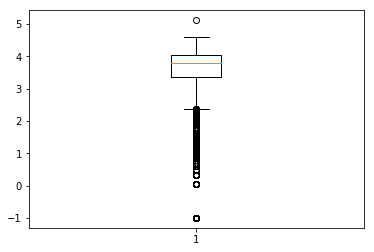

In [21]:
data_good_entries=data_good.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
data_good_entries["diff"] = data_good_entries["max"]-data_good_entries["min"]
k = np.log10(data_good_entries["diff"]+0.1)
plt.boxplot(k);

In [24]:
print("From a total of %d remaining devices" % (len(data_not_jumps_entries)))
print("We see %d devices that have negative diff" % len(neg_list))
print("Remaining devices: %d" % len(data_good_entries))

From a total of 4835 remaining devices
We see 71 devices that have negative diff
Remaining devices: 4764


### 1.3 Looking at Top 40 popular entries by Device

Now we have the data we consider "good" and can look at the Top 40 (~10%) of the devices by cumulative number of entries within the 7 day period. This is the supported data for our suggestions - we want to suggest placing members of WomenTechWomenYes (WTWY) at these locations in order to gather email sign-ups for people that will show up to their Gala free of charge.

In [27]:
data_good_entries.sort_values("diff",ascending=False).head(40)

max         min    diff
STATION         C/A   UNIT SCP                                     
WALL ST         R204  R043 02-06-00      460465      330850  129615
59 ST COLUMBUS  N051  R084 02-00-00    13283135    13242629   40506
14 ST-UNION SQ  A033  R170 02-00-05    16100319    16060153   40166
W 4 ST-WASH SQ  N083  R138 01-06-01    21245719    21206937   38782
BEDFORD AV      H009  R235 00-03-04    10572852    10535763   37089
GRD CNTRL-42 ST R238  R046 00-03-04    37122001    37085154   36847
                R240  R047 00-03-08    38146777    38111855   34922
                R238  R046 00-03-03     5870309     5835563   34746
59 ST COLUMBUS  N051  R084 02-00-01     9420393     9385675   34718
34 ST-HERALD SQ N506  R022 00-05-05      616710      582776   33934
14 ST-UNION SQ  A034  R170 03-03-02    11864716    11830924   33792
                R221  R170 01-00-00    14491482    14457857   33625
59 ST COLUMBUS  N051  R084 02-00-02    24332764    24299437   33327
GRD CNTRL-42 ST R238  R046 00-03-02     3663148     3630290   32858
JAMAICA CENTER  N606  R025 00-00-08    41275429    41242655   32774
86 ST-2 AVE     N701  R571 00-00-00     3652121     3619381   32740
57 ST-7 AV      A011  R080 01-00-04     2870397     2837673   32724
TIMES SQ-42 ST  R151  R033 00-00-01  1718445952  1718413578   32374
8 AV            D002  R390 00-03-01     2499958     2467715   32243
14 ST-UNION SQ  R221  R170 01-00-02    15670498    15638500   31998
                A033  R170 02-00-04     5322544     5290612   31932
34 ST-HERALD SQ A022  R022 01-00-00    26710987    26679306   31681
59 ST COLUMBUS  N051  R084 02-03-03     1847755     1816094   31661
JAMAICA CENTER  N606  R025 00-00-07    27097657    27066387   31270
14 ST-UNION SQ  A037  R170 05-00-02     6706638     6675485   31153
57 ST-7 AV      A010  R080 00-00-07     1705231     1674104   31127
42 ST-PORT AUTH N063A R011 00-00-07    29462308    29431250   31058
14 ST-UNION SQ  A037  R170 05-00-03    25196519    25165551   30968
34 ST-PENN STA  R138  R293 00-00-00     9495898     9465056   30842
FLUSHING-MAIN   R533  R055 00-03-00    15465512    15434853   30659
72 ST           R161A R452 01-06-01    11754657    11724220   30437
JAMAICA CENTER  N606  R025 00-00-06    10372726    10342411   30315
34 ST-HERALD SQ N507  R023 00-03-06     4335639     4305742   29897
34 ST-PENN STA  R138  R293 00-00-01     9639392     9609556   29836
72 ST-2 AVE     N700  R570 00-03-03     3281085     3251333   29752
34 ST-HERALD SQ A025  R023 01-03-02      688109      658611   29498
30 AV           R513  R093 00-03-02     1011032      981855   29177
42 ST-PORT AUTH N063A R011 00-00-03     3493688     3464567   29121
59 ST COLUMBUS  N051  R084 02-00-03    16716468    16687456   29012
14 ST           N078  R175 01-06-03   123174124   123145473   28651

However, this is not our first MVP (Minimal Viable Product) - We believe we can make it more robust by looking at dataset over a longer period of time - 3 Months.

## 2. First MVP (Minimal Viable Product) - Iterating our dataset over 3 months of data

In order to run it again with 3 months of data, we read 12 turnstile data files and concatenate all resulting Pandas DataFrame into a single DataFrame object:

In [37]:
dates_list=['190112','190119','190126','190202','190209','190216','190223','190302','190309','190316','190323','190330']
full_data=pd.DataFrame()
for date in dates_list:
    full_data = pd.concat([full_data, pd.read_csv("http://web.mta.info/developers/data/nyct/turnstile/turnstile_"+date+".txt")])


In [45]:
full_data.reset_index(inplace=True)
full_data.drop(['index'],axis=1,inplace=True)#'level_0','index'],axis=1,inplace=True)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,03:00:00,REGULAR,6897012,2338472
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,07:00:00,REGULAR,6897023,2338487
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,11:00:00,REGULAR,6897083,2338565
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,15:00:00,REGULAR,6897262,2338624
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,19:00:00,REGULAR,6897572,2338679
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,23:00:00,REGULAR,6897740,2338703
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,03:00:00,REGULAR,6897782,2338707
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,07:00:00,REGULAR,6897793,2338714
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,11:00:00,REGULAR,6897854,2338762
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,15:00:00,REGULAR,6898015,2338818


Having concatenated the dataframes, we can sort by the device and then by time to get it in chronological order:

In [46]:
full_data_sorted=full_data.sort_values(['C/A','UNIT','SCP','DATE','TIME'])

To confirm that they ARE in chronological order:

In [50]:
first = np.array(["A002","R051","02-00-00"])
cols = ["C/A","UNIT","SCP"]
    
full_data_sorted[(full_data_sorted[cols]==first).all(1)].head(50)

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,03:00:00,REGULAR,6897012,2338472
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,07:00:00,REGULAR,6897023,2338487
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,11:00:00,REGULAR,6897083,2338565
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,15:00:00,REGULAR,6897262,2338624
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,19:00:00,REGULAR,6897572,2338679
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,23:00:00,REGULAR,6897740,2338703
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,03:00:00,REGULAR,6897782,2338707
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,07:00:00,REGULAR,6897793,2338714
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,11:00:00,REGULAR,6897854,2338762
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,15:00:00,REGULAR,6898015,2338818


In [52]:
full_data_sorted["DATETIME"]=full_data_sorted["DATE"]+' '+full_data_sorted["TIME"]
full_data_sorted["DATETIME"]=pd.to_datetime(full_data_sorted["DATETIME"])

KeyboardInterrupt: 

In [53]:
full_data_sorted

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATETIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,03:00:00,REGULAR,6897012,2338472,01/05/2019 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,07:00:00,REGULAR,6897023,2338487,01/05/2019 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,11:00:00,REGULAR,6897083,2338565,01/05/2019 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,15:00:00,REGULAR,6897262,2338624,01/05/2019 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,19:00:00,REGULAR,6897572,2338679,01/05/2019 19:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/05/2019,23:00:00,REGULAR,6897740,2338703,01/05/2019 23:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,03:00:00,REGULAR,6897782,2338707,01/06/2019 03:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,07:00:00,REGULAR,6897793,2338714,01/06/2019 07:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,11:00:00,REGULAR,6897854,2338762,01/06/2019 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,01/06/2019,15:00:00,REGULAR,6898015,2338818,01/06/2019 15:00:00


Now we are ready to clean the data again as was in Section 1 and arrive to our result.

### 2.1. Separate out devices with large jumps in entry values

In [73]:
FULL_MAX_PEOPLE = MAX_PEOPLE * 12

full_data_entries=full_data_sorted.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
full_data_entries["diff"] = full_data_entries["max"]-full_data_entries["min"]
full_jumps = full_data_entries[full_data_entries["diff"] > FULL_MAX_PEOPLE].reset_index()
full_rest = full_data_entries[full_data_entries["diff"] <= FULL_MAX_PEOPLE]



In [74]:
print("From a total of %d devices" % (len(full_data_entries)))
print("We see %d devices that have large jumps" % len(full_jumps))
print("Remaining devices: %d" % len(full_rest))

From a total of 4905 devices
We see 109 devices that have large jumps
Remaining devices: 4796


In [75]:
a_full=list(full_jumps["C/A"])
b_full=list(full_jumps["UNIT"])
c_full=list(full_jumps["SCP"])
d_full=list(full_jumps["STATION"])

full_data_not_jumps=full_data_sorted

for i in range(len(full_jumps)):
    full_jump_cond = np.array([a_full[i],b_full[i],c_full[i],d_full[i]])
    cols = ["C/A","UNIT","SCP","STATION"]
    
    full_data_not_jumps = full_data_not_jumps[~((full_data_not_jumps[cols]==full_jump_cond).all(1))]

In [76]:
print("Number of Original Datapoints: ", len(full_data_sorted))
print("Number of Datapoints after \"Jump\" data is taken out: ",len(full_data_not_jumps))

Number of Original Datapoints:  2438140
Number of Datapoints after "Jump" data is taken out:  2383680


### 2.2. Separate out devices with entry values declining over time

In [77]:
full_data_not_jumps.head(5)
full_data_not_jumps_entries=full_data_not_jumps.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
full_data_not_jumps_entries["diff"] = full_data_not_jumps_entries["max"]-full_data_not_jumps_entries["min"]
print("Remaining number of device is still",len(full_data_not_jumps_entries))


Remaining number of device is still 4796


In [78]:
FULL_NEGATIVE_LIST=[]

for i in range(len(full_data_not_jumps.index)-1):
    
    entry_1 = full_data_not_jumps.iloc[i,ENTRY_INDEX]
    entry_2 = full_data_not_jumps.iloc[i+1,ENTRY_INDEX]
    time_1 = full_data_not_jumps.iloc[i,DATETIME_INDEX]
    time_2 = full_data_not_jumps.iloc[i+1,DATETIME_INDEX]
    CA1 = full_data_not_jumps.iloc[i,CA_INDEX]
    CA2 = full_data_not_jumps.iloc[i+1,CA_INDEX]
    UNIT1 = full_data_not_jumps.iloc[i,UNIT_INDEX]
    UNIT2 = full_data_not_jumps.iloc[i+1,UNIT_INDEX]
    SCP1 = full_data_not_jumps.iloc[i,SCP_INDEX]
    SCP2 = full_data_not_jumps.iloc[i+1,SCP_INDEX]
    
    
    if (CA1==CA2) & (SCP1==SCP2) & (UNIT1==UNIT2): # if the two entries are of the same device
        # If the 2nd entry-1st entry is negative
        if (entry_2-entry_1)<0:
            FULL_NEGATIVE_LIST.append([CA1,UNIT1,SCP1])

In [79]:
full_neg_set = set(map(tuple,FULL_NEGATIVE_LIST))  # need to convert the inner lists to tuples so they are hashable
full_neg_list=list(full_neg_set)

full_neg_list=(pd.DataFrame(full_neg_list,columns=["C/A","UNIT","SCP"]))
len(full_neg_list)

299

In [80]:
a2=list(full_neg_list["C/A"])
b2=list(full_neg_list["UNIT"])
c2=list(full_neg_list["SCP"])

full_data_good = full_data_not_jumps

for i in range(len(full_neg_list)):
    neg_cond = np.array([a2[i],b2[i],c2[i]])
    cols = ["C/A","UNIT","SCP"]
    
    full_data_good = full_data_good[~((full_data_good[cols]==neg_cond).all(1))]

In [81]:
print("Number of Datapoints after \"Jump\" data is taken out:", len(full_data_not_jumps))
print("Number of Datapoints after \"negative diff\" data is taken out: ",len(full_data_good))

Number of Datapoints after "Jump" data is taken out: 2383680
Number of Datapoints after "negative diff" data is taken out:  2236759


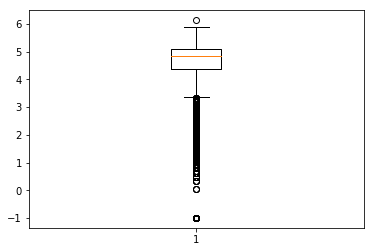

In [82]:
full_data_good_entries=full_data_good.groupby(['STATION','C/A','UNIT','SCP']).ENTRIES.agg(['max','min'])
full_data_good_entries["diff"] = full_data_good_entries["max"]-full_data_good_entries["min"]
k = np.log10(full_data_good_entries["diff"]+0.1)
plt.boxplot(k);

In [83]:
print("From a total of %d remaining devices" % (len(full_data_not_jumps_entries)))
print("We see %d devices that have negative diff" % len(full_neg_list))
print("Remaining devices: %d" % len(full_data_good_entries))

From a total of 4796 remaining devices
We see 299 devices that have negative diff
Remaining devices: 4497


In [68]:
full_data_good_entries.sort_values("diff",ascending=False).head(40)

,,,,max,min,diff
STATION,C/A,UNIT,SCP,,,
GRD CNTRL-42 ST,R238,R046,00-03-02,3663148,3270065,393083
86 ST-2 AVE,N701,R571,00-00-00,3652121,3264876,387245
57 ST-7 AV,A010,R080,00-00-07,1705231,1318948,386283
JAMAICA CENTER,N606,R025,00-00-08,41275429,40889256,386173
59 ST COLUMBUS,N051,R084,02-00-02,24332764,23948504,384260
8 AV,D002,R390,00-03-01,2499958,2118005,381953
34 ST-PENN STA,R138,R293,00-00-00,9495898,9116117,379781
42 ST-PORT AUTH,N063A,R011,00-00-07,29462308,29093592,368716
TIMES SQ-42 ST,R151,R033,00-00-01,1718445952,1718077537,368415
